<a href="https://colab.research.google.com/github/Md-Tasfiq-Rahman/Matlab_practice/blob/main/KPCL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras import layers, models, metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree

from keras.models import Model, Sequential
from keras.layers import Input, Conv1D, Dense, Dropout, Flatten
from keras import optimizers

In [2]:
cldt = pd.read_csv("/content/drive/MyDrive/Power/Fault Data/Tasfiq/csv file/KPCL.csv")
#ddt = pd.read_csv("../input/electrical-fault-detection-and-classification/detect_dataset.csv")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
cldt=cldt.dropna()

In [5]:
cldt['fault_types'] = cldt['G'].astype('str') + cldt['C'].astype('str') + cldt['B'].astype('str') + cldt['A'].astype('str')

categories = ["NF", "LG", "LL", "LLG", "Symmetric"]
encode = {"fault_types":
         {
             "0000" : 0,
             "1001" : 1,
             "0110" : 2,
             "1011" : 3,
             "0111" : 4,
             "1111" : 4
         }}

cldt.replace(encode, inplace = True)

In [6]:
cldt

,G,C,B,A,Ia,Ib,Ic,Va,Vb,Vc,fault_types
0,0,0,0,0,-178.684039,-96.729199,271.538373,-156.890337,-116019.179100,116176.06940,0
1,0,0,0,0,-178.517327,-96.856258,271.501284,-108.242523,-116001.793300,116110.03580,0
2,0,0,0,0,-178.398895,-97.012961,271.539488,-64.643565,-116012.824600,116077.46810,0
3,0,0,0,0,-178.277932,-97.168111,271.573751,-20.782114,-116022.366400,116043.14860,0
4,0,0,0,0,-178.157083,-97.323332,271.608191,23.065691,-116031.973700,116008.90800,0
...,...,...,...,...,...,...,...,...,...,...,...
239996,0,1,1,0,-179.230165,228.697703,-53.086898,-58232.016660,-0.538909,58232.55557,2
239997,0,1,1,0,-179.109532,229.308480,-53.818058,-58191.732370,-0.540785,58192.27316,2
239998,0,1,1,0,-178.988884,229.943426,-54.573400,-58151.447550,-0.542709,58151.99026,2
239999,0,1,1,0,-178.868221,230.598013,-55.348399,-58111.192020,-0.544672,58111.73669,2


In [7]:
def plot_class(fault_type):
    i = categories.index(fault_type)
    print("Plot for fault type =", fault_type)
    fig = plt.figure(figsize = (10,8))
    plt1 = fig.add_subplot(211)
    plt1.plot(cldt[cldt['fault_types'] == i]["Ia"],'r', label = "Ia")
    plt1.plot(cldt[cldt['fault_types'] == i]["Ib"],'b', label = "Ib")
    plt1.plot(cldt[cldt['fault_types'] == i]["Ic"],'g', label = "Ic")
    plt1.legend()

    plt2 = fig.add_subplot(212)
    plt2.plot(cldt[cldt['fault_types'] == i]["Va"],'r', label = "Va")
    plt2.plot(cldt[cldt['fault_types'] == i]["Vb"],'b', label = "Vb")
    plt2.plot(cldt[cldt['fault_types'] == i]["Vc"],'g', label = "Vc")
    plt2.legend()
    plt.show()

Plot for fault type = NF


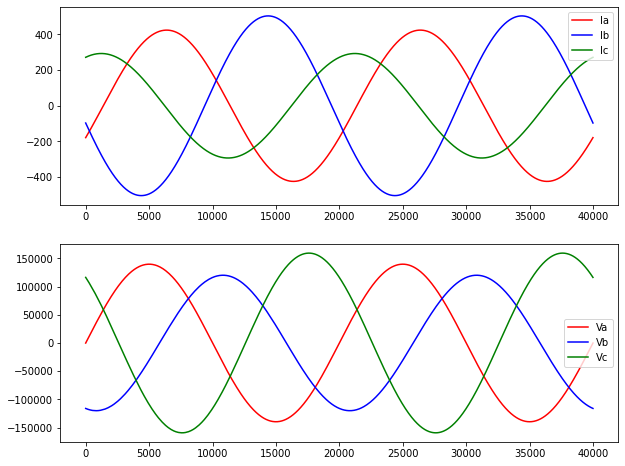

Plot for fault type = LG


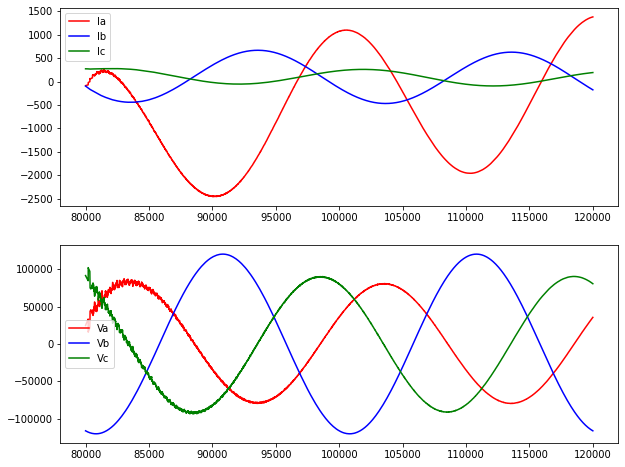

Plot for fault type = LL


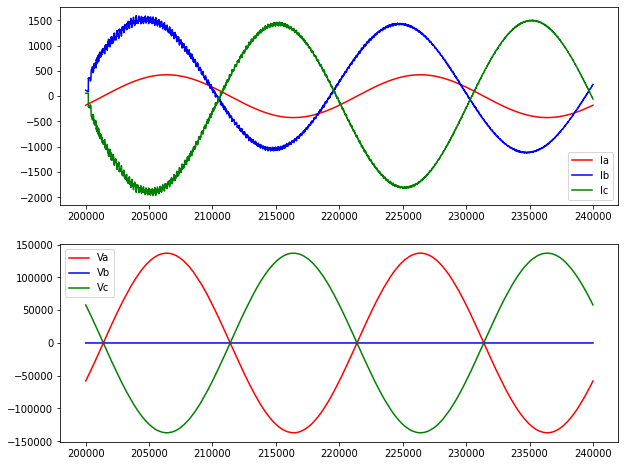

Plot for fault type = LLG


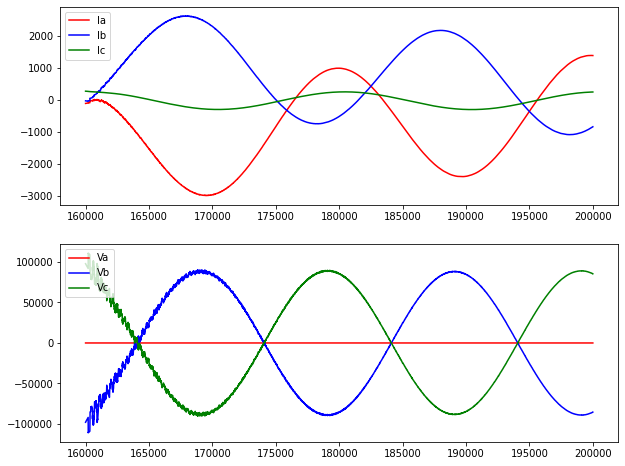

Plot for fault type = Symmetric


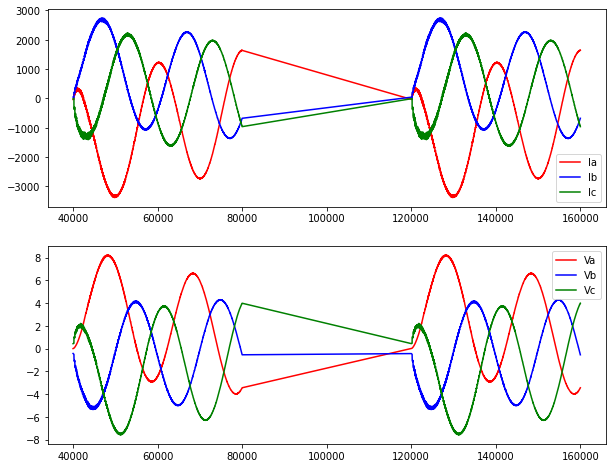

In [8]:
for x in categories:
    plot_class(x)

In [9]:
X = cldt.iloc[:, 4:-1]
X = X / X.max(axis = 0)
y = cldt.iloc[:, -1]

In [10]:
X

,Ia,Ib,Ic,Va,Vb,Vc
0,-0.108659,-0.035248,0.121683,-0.001124,-0.966733,0.729842
1,-0.108558,-0.035294,0.121667,-0.000776,-0.966589,0.729427
2,-0.108486,-0.035351,0.121684,-0.000463,-0.966680,0.729223
3,-0.108412,-0.035408,0.121699,-0.000149,-0.966760,0.729007
4,-0.108339,-0.035464,0.121715,0.000165,-0.966840,0.728792
...,...,...,...,...,...,...
239996,-0.108991,0.083337,-0.023790,-0.417219,-0.000004,0.365829
239997,-0.108918,0.083559,-0.024117,-0.416930,-0.000005,0.365576
239998,-0.108845,0.083791,-0.024456,-0.416642,-0.000005,0.365323
239999,-0.108771,0.084029,-0.024803,-0.416353,-0.000005,0.365070


In [11]:
y.value_counts()

4    80000
0    40001
1    40000
3    40000
2    40000
Name: fault_types, dtype: int64

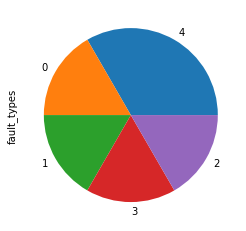

In [12]:
cldt.fault_types.value_counts().plot.pie()
plt.show()

In [13]:
X_final = np.array(X)
y_final = np.array(y)

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=150)

In [15]:
def model_train(model, epochs, feature, label, summary):

    model.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
    )
    if summary:
        print(model.summary())
        
    model.fit(
    feature,
    label,
    validation_split=0.3,
    batch_size=32,
    epochs=epochs,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=patience,
            restore_best_weights=True
        )
    ]
)

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

def model_report(pred, label, report):
    # for classification report, use report = "classification"
    # for confusion matrix, use report = "confusion_matrix"
    p = []

    for i in range(label.shape[0]):
            p.append(np.argmax(pred[i]))

    y_truth = label.flatten().tolist()

    if report == "classification":
        print(classification_report(y_truth, p, target_names = categories))
        
    if report == "confusion_matrix":
        cm = confusion_matrix(y_truth, p)
        disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=categories)
        
        plt.figure(figsize=(8, 8))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
        plt.xticks(np.arange(len(categories)) + 0.5, categories)
        plt.yticks(np.arange(len(categories)) + 0.5, categories)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()

In [17]:
epochs = 8
patience = 20
output_shape = 6
input_shape = X.shape[1]
X_train.shape, y_train.shape

((168000, 6), (168000,))

In [18]:
def cnn_model():
    # Input Layer
    input_layer = Input(shape = (input_shape, 1))
    
    # Convolution Layer
    X = Conv1D(filters = 64, kernel_size = 3, padding = 'same', activation = 'relu')(input_layer)
    
    X = Conv1D(filters = 128, kernel_size = 3, padding = 'same', activation = 'relu')(X)
    
    X = Conv1D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu')(X)
    
    X = Flatten()(X)
    # Dense Layers
    X = Dense(128, activation = 'relu')(X)
    X = Dropout(0.3)(X)
    
    X = Dense(64, activation = 'relu')(X)
    X = Dropout(0.2)(X)

    X = Dense(output_shape, activation = 'softmax')(X)
    
    model = Model(input_layer, X, name = 'cnn_model')
    
    return model

In [19]:
cnn = cnn_model()

In [20]:
model_train(cnn, epochs, X_train, y_train, summary = True)

Model: "cnn_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 1)]            0         
                                                                 
 conv1d (Conv1D)             (None, 6, 64)             256       
                                                                 
 conv1d_1 (Conv1D)           (None, 6, 128)            24704     
                                                                 
 conv1d_2 (Conv1D)           (None, 6, 32)             12320     
                                                                 
 flatten (Flatten)           (None, 192)               0         
                                                                 
 dense (Dense)               (None, 128)               24704     
                                                                 
 dropout (Dropout)           (None, 128)               0 

In [21]:
pred = cnn.predict(X_test)
model_report(pred, y_test, report = "classification")

              precision    recall  f1-score   support

          NF       0.99      1.00      1.00     11888
          LG       1.00      0.99      1.00     12061
          LL       1.00      1.00      1.00     12090
         LLG       1.00      1.00      1.00     11774
   Symmetric       1.00      1.00      1.00     24188

    accuracy                           1.00     72001
   macro avg       1.00      1.00      1.00     72001
weighted avg       1.00      1.00      1.00     72001



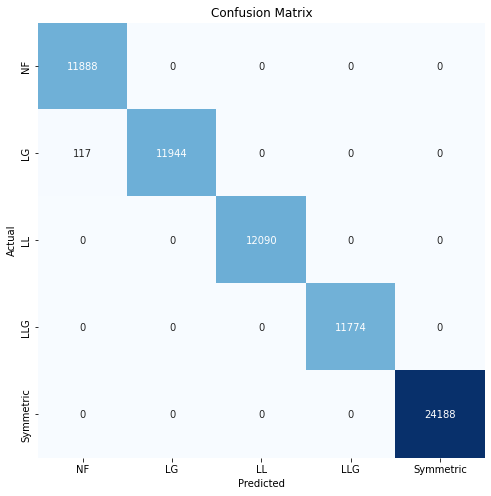

In [22]:
model_report(pred, y_test, report = "confusion_matrix")

In [23]:
inputs = Input(shape=(input_shape,))

expand_dims = tf.expand_dims(inputs, axis=2)

gru = layers.GRU(2048, return_sequences=True)(expand_dims)

gru = layers.GRU(1024, return_sequences=True)(gru)

flatten = Flatten()(gru)

outputs = Dense(output_shape, activation='softmax')(flatten)


model_gru = Model(inputs=inputs, outputs=outputs)

In [24]:
model_train(model_gru, epochs, X_train, y_train, summary = True)

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 6)]               0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 6, 1)             0         
                                                                 
 gru (GRU)                   (None, 6, 2048)           12601344  
                                                                 
 gru_1 (GRU)                 (None, 6, 1024)           9443328   
                                                                 
 flatten_1 (Flatten)         (None, 6144)              0         
                                                                 
 dense_3 (Dense)             (None, 6)                 36870     
                                                                 
Total params: 22,081,542
Trainable params: 22,081,542
Non-tra

In [25]:
pred = model_gru.predict(X_test)
model_report(pred, y_test, report = "classification")

              precision    recall  f1-score   support

          NF       1.00      1.00      1.00     11888
          LG       1.00      1.00      1.00     12061
          LL       1.00      1.00      1.00     12090
         LLG       1.00      1.00      1.00     11774
   Symmetric       1.00      1.00      1.00     24188

    accuracy                           1.00     72001
   macro avg       1.00      1.00      1.00     72001
weighted avg       1.00      1.00      1.00     72001



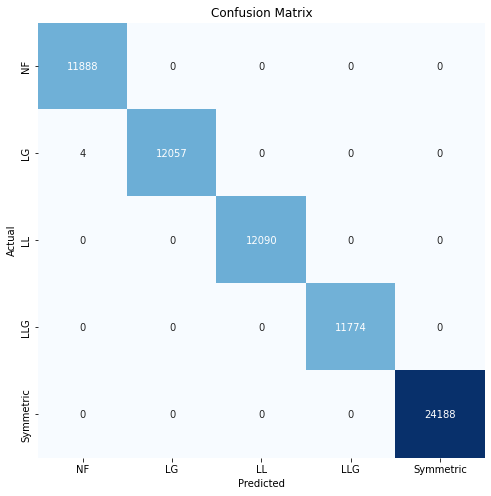

In [26]:
model_report(pred, y_test, report = "confusion_matrix")

In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

dtf = DecisionTreeClassifier()
dtf.fit(X_train, y_train)
pred = dtf.predict(X_test)

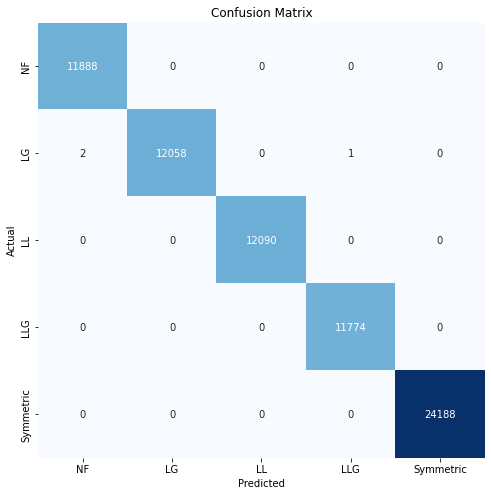

In [28]:
cm = confusion_matrix(y_test, pred)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels=categories)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cbar=False, cmap='Blues')
plt.xticks(np.arange(len(categories)) + 0.5, categories)
plt.yticks(np.arange(len(categories)) + 0.5, categories)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [29]:
print(classification_report(y_test, pred, target_names = categories))

              precision    recall  f1-score   support

          NF       1.00      1.00      1.00     11888
          LG       1.00      1.00      1.00     12061
          LL       1.00      1.00      1.00     12090
         LLG       1.00      1.00      1.00     11774
   Symmetric       1.00      1.00      1.00     24188

    accuracy                           1.00     72001
   macro avg       1.00      1.00      1.00     72001
weighted avg       1.00      1.00      1.00     72001



In [30]:
performance1 = cnn.evaluate(X_test, y_test)
performance2 = model_gru.evaluate(X_test, y_test)
performance3 = accuracy_score(dtf.predict(X_test), y_test)

2251/2251 [==============================] - 20s 9ms/step - loss: 2.5175e-04 - accuracy: 0.9999


In [31]:
print("CNN model accuracy:", performance1[1] * 100, "%")
print("GRU model accuracy", performance2[1] * 100, "%")
print("DecisionTreeClassifier model accuracy", performance3 * 100, "%")

CNN model accuracy: 99.83749985694885 %
GRU model accuracy 99.99444484710693 %
DecisionTreeClassifier model accuracy 99.99583339120291 %


In [32]:
cnn.save("/content/drive/MyDrive/Power/KPCL/cnn/kpclcnn.h5")

In [33]:
model_gru.save("/content/drive/MyDrive/Power/KPCL/gru/kpclgru.h5")

In [34]:
k=dtf.fit(X_train, y_train)

In [35]:
k=tree.DecisionTreeClassifier()